# ТТ-разложение тензоров
## Введение
Если говорить неформально, то тензор - это просто многомерный массив данных.         
В современных реалиях развития различных сфер программирования интерес к работе с тензорами растет от года к году. Чаще всего тензоры используются в машинном обучении и близких к нему сферах.      
Помимо этого, тензоры играют огромную роль в вычислениях в некоторых областях физики. 

## Терминология
Введем следующую обозначения: 
* d - размерность, то есть количество индексов, 
* n = ${n_1 * n_2 * ... * n_d}$ - размер, то есть произведение количеств элементов на каждой оси. 

## Разложения тензоров
Одной из главных сложностей при работе с тензорами является так называемое "проклятие размерности". Оно заключается в том, что тензор занимает ${O(n^d)}$ памяти, что, несомненно, при больших d становится серьезной проблемой. 
Поэтому проблема поиска эффективного разложения и представления в памяти оставалась и остается акутальной.          

Одним из таких разложений является *Каноническое разложение (Canonical decomposition)*:         
Пусть у нас есть тензор ${A}$ с элементами ${A(i_1, i_2,...,i_d)}$, ${r}$ - ранг тензора (канонический ранг). Тогда $$A(i_1, i_2,...,i_d) = \sum_{\alpha = 1}^{r}U_1(i_1, \alpha)U_2(i_2, \alpha)...U_d(i_d, \alpha)$$ Преимуществом этого формата является количество параметров в разложении - ${O(dnr)}$. Но проблема заключается в том, что вычисление канонического ранга тензора - это NP-сложная задача, соответственно такое разложение подходит лишь для низкоранговых тензоров. 

Следующим известным разложением является *Разложение Таккера (The Tucker format)*:
$$A(i,j,k) \approx \sum_{\alpha, \beta, \gamma} G(\alpha, \beta, \gamma)U_1(i_1, \alpha)U_2(i_2, \beta)U_3(i_3, \gamma) $$
Проблемой этого разложения является количество параметров - ${O(dnr + r^d)}$. Проклятие размерности не уходит, но для низкоранговых тензоров разложение Таккера является довольно эффективным. 

## ТТ-разложение 
ТТ-разложение (tensor train decomposition) - разложение, рассматриваемое в этой работе.        
Мы приближаем данный тензор ${B}$ с помощью тензора ${A \approx B}$  с элементами $$A(i_1, i_2,...,i_d) = G_1(i_1)G_2(i_2)...G_d(i_d),$$
где ${G_k(i_k)}$ - матрица размера ${r_{k-1} * r_{k}}$.       
В индексной форме это может быть переписано следующим образом: $$A(i_1,...,i_d) = \sum_{\alpha_0,...,\alpha_{d-1}, \alpha_d}G_1(\alpha_0, i_1, \alpha_1)G_2(\alpha_1, i_2, \alpha_2)...G_d(\alpha_{d-1}, i_d, \alpha_d)$$

Отдельно стоит сказать про ТТ-ранги. ТТ-ранги - это ранги матриц разверток (unfolding matrices).             
У каждого тензора есть ${d - 1}$ матрица развертки: 
$$A_k = [A(i_1...i_k;i_{k+1}...i_d)],$$где $$A(i_1...i_k;i_{k+1}...i_d) = A(i_1,...,i_d)$$
В данном случае ${i_1...i_k}$ и ${i_{k+1}...i_d}$ - мультииндексы строк и столбцов.                    
Матрица ${A_k}$ имеет размер ${M_k * N_k}$, где ${M_k = \prod_{s = 1}^{k}n_s}$ и ${N_k = \prod_{s = k+1}^{d}n_s}$. 
Также всегда ${r_0 = r_d = 1}$.                        
В рамках ТТ-формата r = ${\max_{i \in 1...d}r_i}$

ТТ-формат использует ${O(dnr^2)}$ памяти для хранения ${O(n^d)}$. Поэтому данный формат особенно эффективен для низкоранговых тензоров, в таком случае получается справится с проклятием размерности. 

### ТТ-декомпозиция
Одним из основных алгоритмов для ТТ-формата является ТТ-декомпозиция. Его реализация основана на SVD-разложении для тензоров. 
Сам алгоритм приведен в следующем блоке. 



In [0]:
!pip install tensorly

In [0]:
import numpy as np 
import torch
import math
import random
import tensorly as tl
from scipy.linalg import svd

def tt_svd(tt, accuracy, d, dimensions):
    delta = 0
    if d == 1:
        delta = math.ceil((accuracy / math.sqrt(d)) * torch.norm(torch.Tensor(tt), p = 'fro'))
    else:
        delta = math.ceil((accuracy / math.sqrt(d - 1)) * torch.norm(torch.Tensor(tt), p = 'fro'))
    C = tt
    ranks = [1]
    cores = []
    for k in range(1, d):
        size = C.size
        C = np.reshape(C, [ranks[k - 1] * dimensions[k], size // (ranks[k - 1] * dimensions[k])])
        rank = min(delta, np.linalg.matrix_rank(tl.unfold(tt, mode = k - 1)))
        U, S, V = tl.partial_svd(C, rank)
        ranks.append(rank)
        cores.append(np.reshape(U, (ranks[k-1], dimensions[k], ranks[k])))
        C = tl.reshape(S, (-1, 1)) * V
    cores.append(C)
    ranks.append(1)
    del tt
    return cores, max(ranks), ranks

#### Эксперимент
Проведем следующий эксперимент:           
1. Генерируем случайным образом тензор размерности от 1 до 6. 
2. Сравниваем время работы следующих разложений этого тензора: библиотечную реализацию разложения Такера, библиотечную реализацию ТТ-разложения, мою собственную реализацию ТТ-разложения. 

In [0]:
import time
from tensorly.decomposition import tucker, matrix_product_state
from numpy.linalg import matrix_rank

dimensions = []
eps = random.random()
lib_tt_time = []
tucker_time = []
my_tt_time = []
Ranks = []
for i in range(1):
    exec_time = []
    prod_dim = [1]
    product_of_dims = 1
    for d in range(1, 7):
        tt_ranks = []
        
        dim = random.randint(1, 7)
        product_of_dims *= dim
        prod_dim.append(product_of_dims)
        dimensions.append(dim)
        
        #generate tensor
        A = np.random.random(dimensions)
        
        #tucker
        start_time = time.time()
        core1, factores = tucker(A, ranks = dimensions)
        t_t = time.time() - start_time
        tucker_time.append(t_t)
        
        #tt-svd-by-me
        start_time = time.time()
        core, rank, tt_ranks = tt_svd(A, eps, d, dim, dimensions)
        tt_t = time.time() - start_time
        my_tt_time.append(tt_t)
        Ranks.append(rank)
        
        if d > 1:
            #tt-svd-in-lib
            start_time = time.time()
            try:
                factors = matrix_product_state(A, tt_ranks)
                lib_tt_time.append(time.time() - start_time)
            except ValueError:
                lib_tt_time.append(lib_tt_time[-1] + 0.00001)
        else:
            lib_tt_time.append(tucker_time[0] - 0.00001)   

#### График
Начертим график.                 
*Ось x* - максимум ТТ-рангов тензора, *ось y* - время работы алгоритма соответствующего легенде графика разложения. 

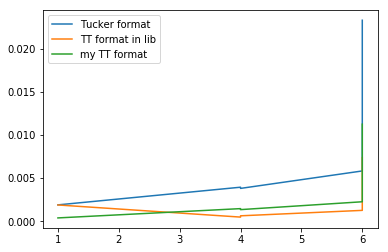

In [0]:
import matplotlib.pyplot as plt 


plt.plot(Ranks, tucker_time, label = 'Tucker format')
plt.plot(Ranks, lib_tt_time, label = 'TT format in lib')
plt.plot(Ranks, my_tt_time, label = 'my TT format')
plt.legend()

#### Результаты эксперимента 
Резлультаты соотвествуют теории.                
На графике видно, что библиотечная реализация ТТ-разложения работает быстрее моей, но, в целом, время работы отличается несильно при любой размерности. Что же касается разложения Такера, то, как отмечалось выше, оно действительно эффективно при маленьких размерностях, но уже при размерности более 4 становится видно, что время работы этого разложения значительно больше любой реализации ТТ-разложения. 

### Базовые операции с тензорами в ТТ-формате
#### Сложение              
Пусть у нас есть два тензора в ТТ-формате ${A = A_1(i_1)...A_d(i_d)}$ и ${B = B_1(i_1)...B_d(i_d)}$.                 
Тогда ${C = A + B}$ в ТТ-формате представляется следующим образом: 
$$C_k(i_k) = 
\begin{pmatrix}
A_k(i_k) & 0 \\
0 & B_k(i_k)
\end{pmatrix}, \;k = 2,...,d-1$$ 
и 
$$C_1(i_1) = \begin{pmatrix} A_1(i_1) & B_1(i_1) \end{pmatrix}, \;\; 
C_d(i_d) = \begin{pmatrix} A_d(i_d) \\ B_d(i_d) \end{pmatrix}$$

При выполнении сложения ТТ-ранги удваиваются.         
Асимптотика операции - ${O(dnr^2 + dr^4)}$

В следующем блоке код, выполняющий сложение. 

In [0]:
def sum_of_tensors(a_cores, b_cores):
    c_size = len(a_cores)
    print(c_size)
    #print(c_size)
    c_cores = []
    c_cores.append([a_cores[0][0], b_cores[0][0]])
    for k in range(1, c_size-1):
        c_cores.append([[a_cores[k][k], 0], [0, b_cores[k][k]]])
    c_cores.append([[a_cores[c_size-1][c_size-1]], [b_cores[c_size-1][c_size-1]]])
    return c_cores

#### Умножение на скаляр
Умножить на скаляр тензор в ТТ-формате очень просто - нужно лишь умножить какое-нибудь из ядер на этот скаляр. 

В следующем блоке код, выполняющий умножение на скаляр. Данная реализация умножает на скаляр первое ядро.

In [0]:
def prod_by_scalar(cores_a, x):
    for i in range(len(cores)):
        for j in range(len(cores[0])):
            for k in range(len(cores[0][0])):
                cores[i][j][k] *= x 
    return cores

#### Многомерная свертка 
Пусть у нас есть некоторый тензор ${T}$. 
Тогда его многомерной сверткой называется следующее представление этого тензора: 
$$T = \sum_{i_1,...,i_d}A(i_1,...,i_d)u_1(i_1)...u_d(i_d),$$ 
где ${u_k(i_k)}$ - это векторы длины ${n_k}$. 

Теперь рассмотрим как произвести эту операцию с тензором в ТТ-формате. 
Пусть $$T = G_1(i_1)...G_d(i_d), $$
тогда многомерная свертка будет выглядеть следующим образом:
$$T = \begin{pmatrix}\sum_{i_1}u_1(i_1)G_1(i_1)\end{pmatrix}...\begin{pmatrix}\sum_{i_d}u_d(i_d)G_d(i_d)\end{pmatrix},$$
или, введя следующее обозначение: 
$$Г_k = \sum_{i_k}u_k(i_k)G_k(i_k),$$
где ${Г_k}$ - матрица размера ${r_{k-1} * r_k},$ многомерную свертку тензора ${T}$ можно записать следующим образом: 
$$T = Г_1...Г_d.$$

Асимптотика операции - ${O(dnr + dr^3)}$.

#### Поэлементное произведение (произведение Адамара)

Поэлементным произведением двух тензоров ${A}$ и ${B}$ называется следующий тензор ${C}$: 
$$C(i_1,...,i_d) = A(i_1,...,i_d)B(i_1,...,i_d)$$

В ТТ-формате тензор ${C}$ считается следующим образом:
$$C(i_1,...,i_d) = A_1(i_1)...A_d(i_d)B_1(i_1)...B_d(i_d) = \\ =\begin{pmatrix}A_1(i_1)...A_d(i_d)\end{pmatrix} \otimes \begin{pmatrix}B_1(i_1)...B_d(i_d)\end{pmatrix} = \\
=\begin{pmatrix}A_1(i_1) \otimes B_1(i_1)\end{pmatrix}\begin{pmatrix}A_2(i_2) \otimes B_2(i_2)\end{pmatrix}...\begin{pmatrix}A_d(i_d) \otimes B_d(i_d)\end{pmatrix},
$$ где ${\otimes}$ обозначает кронекерово произведение. 

После выполнения этой операции ТТ-ранги тензора ${C}$ равны произведению соответствующих ТТ-рангов тензоров ${A}$ и ${B}$. 

Асимптотика операции - ${O(dnr^4)}$. 

#### Скалярное произведение
Скалярное произведение - важная операция для многих приложений.        
Для тензоров ${A}$ и ${B}$, представленных в ТТ-формате, скалярное произведение высчитывается с помощью произведения Адамара следующим образом: 
$$\langle A, B \rangle = \sum_{i_1...i_d}A(i_1,...,i_d)B(i_1,...,i_d) = \sum_{i_1...i_d}C(i_1,...,i_d), $$
где ${C}$ - это результат поэлементного произведения тензоров ${A}$ и ${B}$. 

С помощью скалярного произведения легко вычислить **Фробениусову норму** тензора. Пусть у нас есть тензор A. Тогда его фробениусова норма равна: 
$$||A||_F = \sqrt{\langle A, B \rangle}$$.

Также можно посчитать расстояние между двумя тензорами. Пусть у нас есть тензоры A и B. Тогда расстояние между ними вычисляется следующим образом: 
$$\rho(A,B) = ||A-B||_F$$.

Асимптотика нахождения скалярного произведения и фробениусовой нормы - ${O(dnr^2 + dr^4)}$.


### ТТ-округление
Задача заключается в следующем:                  
Пусть у нас есть тензор ${A}$, и мы уже нашли его ТТ-разложение, то есть ${A = A_1(i_1)A_2(i_2)...A_d(i_d)}$. 
Может случиться так, что ТТ-ранги найденного разложения неоптимальны, то есть существуют ранги меньше зафиксированных.        

Формально говоря, в таком случае нужно найти такое TT-приближение ${B \approx A}$, что если ${r'_k}$ - это ТТ-ранги тензора B, а ${r_k}$ - ТТ-ранги тензора A, то ${r'_k \leq r_k \; \forall k}$.

Идея такова:         
Мы умеем считать усеченное SVD-разложение, а также QR-разложение.         
Пройдемся по всем ядрам ТТ-разложения справа налево, сначала находя QR-разложение рассматриваемого ядра, а затем усеченное SVD-разложение.             
В итоге получим ТТ-разложение с оптимизированными ТТ-рангами. 

Асимптотика операции - ${O(dnr^3)}$. 

Стоит сказать, что данная операция имеет огромное значение для всей идеи ТТ-формата, так как именно от ТТ-рангов зависит эффективность использования всех алгоритмов и операций, приведенных выше. 

## Заключение
ТТ-формат - действительно эффективный и удобный способ представления тензора.      
В первую очередь, ТТ-формат во многих случаях позволяют "победить" проклятие размерности. 

Также преимуществом этого представления тензоров является то, что практически все операции можно совершать не переводя тензоры из ТТ-форматы в обычный и обратный.    

ТТ-разложение также известно как *matrix product state*, которое уже довольно давно используется в некоторых областях физики.         

На мой взгляд, ТТ-формат действительно во многом упрощает работу с тензорами. 

ТТ-разложение доступно в таких библиотеках для `Python`, как `TensorFlow`, `Tensorly`, `ttpy` и других, что позволяет еще легче пользоваться всеми преимущетствами этого формата. 